## SepFormer 시도

In [5]:
# 1. 설치
!pip install speechbrain torchaudio soundfile

# 2. SepFormer 모델 로드 (WSJ0-2Mix 버전)
from speechbrain.inference.separation import SepformerSeparation as separator
import torchaudio
import soundfile as sf
from google.colab import files

# GPU 사용하고 싶으면 run_opts에 device 지정
sepformer = separator.from_hparams(
    source="speechbrain/sepformer-wsj02mix",
    savedir="pretrained_models/sepformer-wsj02mix",
    run_opts={"device": "cuda"}  # CPU면 이 줄 빼면 됨
)

print("SepFormer 로딩 완료!")


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/sepformer-wsj02mix/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-wsj02mix' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/sepformer-wsj02mix.
INFO:speechbrain.utils.fetching:Fetch masknet.ckpt: Using symlink found at '/content/pretrained_models/sepformer-wsj02mix/masknet.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["masknet"] = /content/pretrained_models/sepformer-wsj02mix/masknet.ckpt
INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Using symlink found at '/content/pretrained_models/sepformer-wsj02mix/encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["encoder"] = /content/pretrained_models/sepformer-wsj02mix/encoder.ckpt
INFO:speechbrain.utils.fetching:Fetch d

SepFormer 로딩 완료!


### 일단 먼저 sepformer에서 제공하는 데이터셋으로 테스트해보자

In [16]:
# 3. 혼합 음성 파일 업로드
uploaded = files.upload()
mix_path = list(uploaded.keys())[0]
print("입력 파일:", mix_path)

# 4. 분리 수행
est_sources = sepformer.separate_file(path=mix_path)  # shape: (batch, time, n_src)

# 5. 분리된 소스 저장 (2화자 기준)
sr = 8000  # 이 모델은 8kHz 기준
src1 = est_sources[:, :, 0].detach().cpu()
src2 = est_sources[:, :, 1].detach().cpu()

torchaudio.save("speaker1.wav", src1, sr)
torchaudio.save("speaker2.wav", src2, sr)

files.download("speaker1.wav")
files.download("speaker2.wav")

print("완료!")

Saving 침착+나폴리mix2.wav to 침착+나폴리mix2.wav
입력 파일: 침착+나폴리mix2.wav


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

완료!


내가 데이터셋 만들어서 시도해봄

카페는 외부 소음이 너무 많아서 손 봐야할게 많을 것 같음

침착맨과 나폴리맛피자 목소리 두 개 따로 녹음 후 병합

In [4]:
!pip install soundfile
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.6/163.6 kB 3.3 MB/s eta 0:00:00a 0:00:01


In [5]:
import soundfile as sf
import numpy as np
import librosa

def mix_wavs(file1, file2, out="mix.wav", snr=None):
    """
    file1, file2: 입력 wav 파일 경로
    out: 출력 파일 경로
    snr: 원하는 SNR(dB)로 mixing (None이면 단순 합성)
    """

    # 1) wav 읽기 + 샘플링레이트 통일 (자동)
    wav1, sr1 = librosa.load(file1, sr=None, mono=True)
    wav2, sr2 = librosa.load(file2, sr=None, mono=True)

    # 2) 샘플링 레이트가 다르면 가장 높은 SR로 resample
    sr = max(sr1, sr2)
    if sr1 != sr:
        wav1 = librosa.resample(wav1, orig_sr=sr1, target_sr=sr)
    if sr2 != sr:
        wav2 = librosa.resample(wav2, orig_sr=sr2, target_sr=sr)

    # 3) 길이 맞추기 → 더 긴 쪽을 그대로 두고 짧은 쪽은 패딩
    max_len = max(len(wav1), len(wav2))
    if len(wav1) < max_len:
        wav1 = np.pad(wav1, (0, max_len - len(wav1)))
    if len(wav2) < max_len:
        wav2 = np.pad(wav2, (0, max_len - len(wav2)))

    # 4) SNR 기반 mixing (원하면)
    if snr is not None:
        # signal 파워랑 noise 파워 조정하여 snr 맞추기
        power1 = np.mean(wav1**2)
        power2 = np.mean(wav2**2)
        target_power2 = power1 / (10**(snr / 10))
        wav2 = wav2 * np.sqrt(target_power2 / (power2 + 1e-9))

    # 5) 두 음성 합성
    mix = wav1 + wav2

    # 6) 클리핑 방지 → [-1, 1]로 normalize
    m = np.max(np.abs(mix))
    if m > 1:
        mix = mix / m

    # 7) 저장
    sf.write(out, mix, sr)
    print(f"혼합 음성 파일 생성 완료: {out}, 길이: {len(mix)/sr:.2f}초")


In [7]:
mix_wavs("data/창천동.wav", "data/침착맨1.wav", out="data/카페mix.wav")

/var/folders/zx/88x5v8pj1h3g803rndft70xr0000gn/T/ipykernel_97610/3332105028.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  wav1, sr1 = librosa.load(file1, sr=None, mono=True)


혼합 음성 파일 생성 완료: data/카페mix.wav, 길이: 10.17초


/var/folders/zx/88x5v8pj1h3g803rndft70xr0000gn/T/ipykernel_97610/3332105028.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  wav2, sr2 = librosa.load(file2, sr=None, mono=True)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


학습 데이터셋 특성에 맞게 다시 mix

In [15]:
import soundfile as sf
import numpy as np
import librosa

def wsj0_2mix_style_mix(
    spk1_path,
    spk2_path,
    out_path="mix.wav",
    target_sr=8000,           # WSJ0-2mix는 8kHz
    snr_db=0                  # SNR ∈ { -5, 0, +5 }가 기본
):
    """
    WSJ0-2mix 스타일로 두 음성을 합성하는 함수.
    - 8kHz mono 변환
    - 길이 맞추기
    - SNR 조절
    - 동시에 시작(0초 align)
    - normalize
    """
    # -----------------------------------------
    # 1) Load + resample to 8kHz mono
    # -----------------------------------------
    wav1, sr1 = librosa.load(spk1_path, sr=target_sr, mono=True)
    wav2, sr2 = librosa.load(spk2_path, sr=target_sr, mono=True)

    # -----------------------------------------
    # 2) 길이 맞추기 → 더 짧은 쪽을 패딩
    # -----------------------------------------
    max_len = max(len(wav1), len(wav2))
    if len(wav1) < max_len:
        wav1 = np.pad(wav1, (0, max_len - len(wav1)))
    if len(wav2) < max_len:
        wav2 = np.pad(wav2, (0, max_len - len(wav2)))

    # -----------------------------------------
    # 3) SNR을 맞춰서 스케일링
    #    SNR = 10 * log10(P1 / P2)
    # -----------------------------------------
    # 각 화자의 power 계산
    power1 = np.mean(wav1**2) + 1e-9
    power2 = np.mean(wav2**2) + 1e-9

    # target power2 계산
    # P2_new = P1 / (10^(snr/10))
    target_p2 = power1 / (10**(snr_db / 10))

    # scale factor α 계산 (wav2_scaled = wav2 * α)
    scale = np.sqrt(target_p2 / power2)
    wav2_scaled = wav2 * scale

    # -----------------------------------------
    # 4) 두 화자 믹싱
    # -----------------------------------------
    mix = wav1 + wav2_scaled

    # -----------------------------------------
    # 5) Normalize to prevent clipping
    # -----------------------------------------
    max_amp = np.max(np.abs(mix))
    if max_amp > 1:
        mix = mix / max_amp

    # -----------------------------------------
    # 6) Save mixture
    # -----------------------------------------
    sf.write(out_path, mix, target_sr)
    print(f"[완료] WSJ0-2mix 스타일 합성 완료 → {out_path}")
    print(f"샘플레이트: {target_sr} Hz, 길이: {len(mix)/target_sr:.2f}초")
    print(f"SNR(dB) = {snr_db}, scaling = {scale:.3f}")


# 사용 예시
wsj0_2mix_style_mix(
    "/content/나폴리맛피자1.wav", "/content/침착맨1.wav",
    out_path="mix2.wav",
    snr_db=0  # -5, 0, +5 중 하나 추천
)


/tmp/ipython-input-2692333053.py:23: UserWarning: PySoundFile failed. Trying audioread instead.
  wav1, sr1 = librosa.load(spk1_path, sr=target_sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-2692333053.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  wav2, sr2 = librosa.load(spk2_path, sr=target_sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[완료] WSJ0-2mix 스타일 합성 완료 → mix2.wav
샘플레이트: 8000 Hz, 길이: 10.22초
SNR(dB) = 0, scaling = 0.516


# Conv-TasNet 시도

In [17]:
# =========================================
# 1. 설치
# =========================================
!pip install asteroid
!pip install soundfile

import torch
import soundfile as sf
from google.colab import files
from asteroid.models import BaseModel

In [18]:
# =========================================
# 2. Conv-TasNet 모델 로드 (공개 pretrained)
# =========================================
# 16kHz 버전 (추천)
model = BaseModel.from_pretrained("JorisCos/ConvTasNet_Libri2Mix_sepclean_16k")
model.eval()
print("Conv-TasNet 모델 로딩 완료!")

pytorch_model.bin:   0%|          | 0.00/20.4M [00:00<?, ?B/s]

Conv-TasNet 모델 로딩 완료!


In [20]:
# =========================================
# 3. 혼합 음성 파일 업로드
# =========================================
uploaded = files.upload()
mix_path = list(uploaded.keys())[0]
print("입력 파일:", mix_path)

# =========================================
# 4. 음성 로드
# =========================================
wav, sr = sf.read(mix_path)

# Conv-TasNet은 (batch, time) 형태가 필요
wav_tensor = torch.tensor(wav).float().unsqueeze(0)

# 샘플레이트 체크 (필요하면 resample)
if sr != model.sample_rate:
    print(f"⚠ SR mismatch: {sr} → {model.sample_rate}으로 resample 필요")
else:
    print("샘플레이트 OK:", sr)

# =========================================
# 5. 분리 실행
# =========================================
with torch.no_grad():
    est_sources = model(wav_tensor)  # (1, N, T)

est_sources = est_sources.squeeze(0).cpu().numpy()
num_sources = est_sources.shape[0]
print("분리된 음성 개수:", num_sources)

# =========================================
# 6. 결과 저장 + 다운로드
# =========================================
out_files = []
for i in range(num_sources):
    out_path = f"speaker{i+1}.wav"
    sf.write(out_path, est_sources[i], model.sample_rate)
    out_files.append(out_path)
    files.download(out_path)

print("🎉 완료! 분리 파일 다운로드해서 들어봐.")


Saving test_mixture.wav to test_mixture (1).wav
입력 파일: test_mixture (1).wav
샘플레이트 OK: 8000
분리된 음성 개수: 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎉 완료! 분리 파일 다운로드해서 들어봐.


음성 파일 시각화

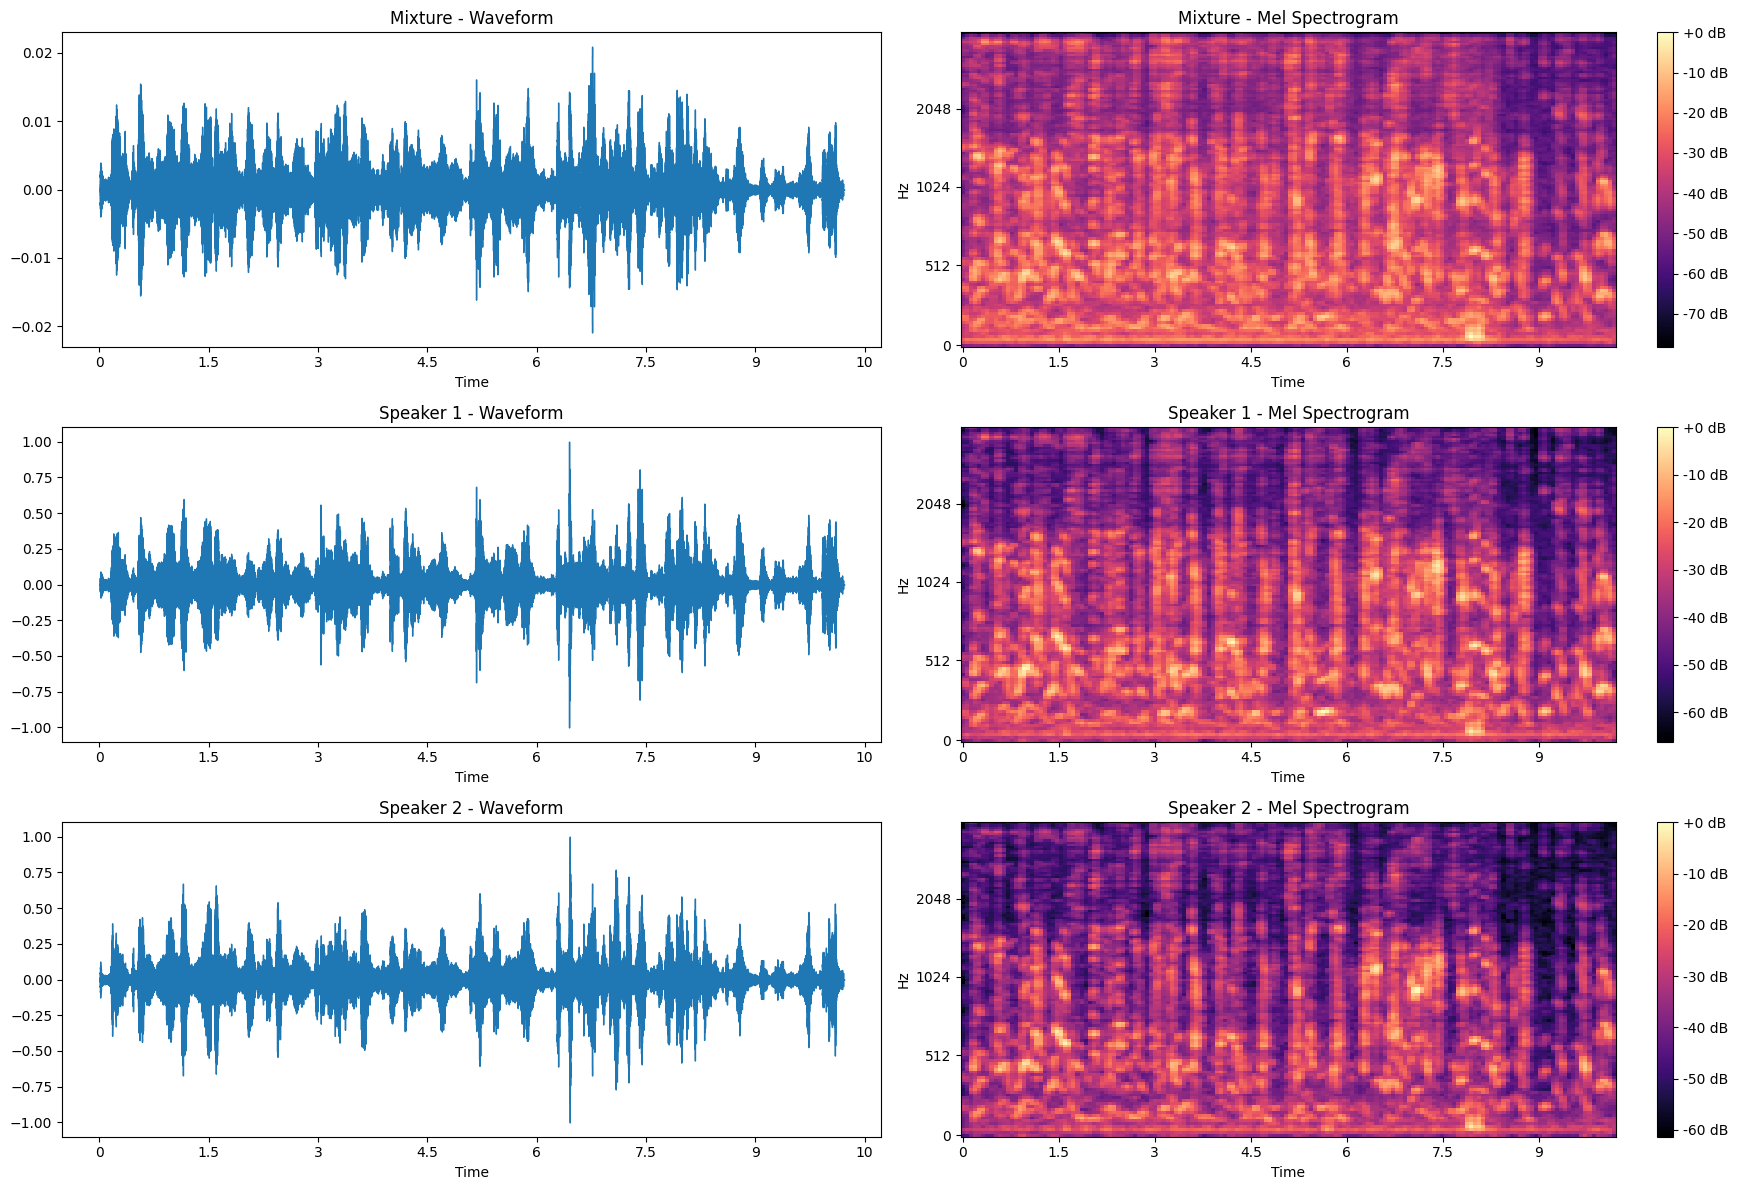

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# 파일 경로 설정
# ==============================
mix_path = "/content/침착+나폴리mix2.wav"
spk1_path = "/content/나폴리mix결과1.wav"
spk2_path = "/content/나폴리mix결과2.wav"

# ==============================
# 음성 로드
# ==============================
mix, sr = librosa.load(mix_path, sr=None)
spk1, _ = librosa.load(spk1_path, sr=sr)
spk2, _ = librosa.load(spk2_path, sr=sr)

# ==============================
# Mel-Spectrogram 생성 함수
# ==============================
def get_mel(y, sr):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

mel_mix = get_mel(mix, sr)
mel_spk1 = get_mel(spk1, sr)
mel_spk2 = get_mel(spk2, sr)

# ==============================
# 시각화
# ==============================
plt.figure(figsize=(18, 12))

# ----- 1) Waveforms -----
plt.subplot(3, 2, 1)
librosa.display.waveshow(mix, sr=sr)
plt.title("Mixture - Waveform")

plt.subplot(3, 2, 3)
librosa.display.waveshow(spk1, sr=sr)
plt.title("Speaker 1 - Waveform")

plt.subplot(3, 2, 5)
librosa.display.waveshow(spk2, sr=sr)
plt.title("Speaker 2 - Waveform")

# ----- 2) Mel-Spectrograms -----
plt.subplot(3, 2, 2)
librosa.display.specshow(mel_mix, sr=sr, x_axis="time", y_axis="mel", cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("Mixture - Mel Spectrogram")

plt.subplot(3, 2, 4)
librosa.display.specshow(mel_spk1, sr=sr, x_axis="time", y_axis="mel", cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("Speaker 1 - Mel Spectrogram")

plt.subplot(3, 2, 6)
librosa.display.specshow(mel_spk2, sr=sr, x_axis="time", y_axis="mel", cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("Speaker 2 - Mel Spectrogram")

plt.tight_layout()
plt.show()
